# Gaussian Mixture Model for Expectation Maximization


In [1]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os
import kagglehub

In [3]:
# Download latest version of the dataset
path = kagglehub.dataset_download("nigelwilliams/ngsim-vehicle-trajectory-data-us-101")

print("Path to dataset files:", path)

In [ ]:
data_file = "./dataset/trajectories-0750am-0805am.txt"

# Load the dataset
df = pd.read_csv(data_file, sep="\s+", header=None)

# Check the number of columns in the dataset
print(f"Number of columns in the dataset: {df.shape[1]}")

# Adjust the column names list based on the number of columns
# Let's print the first few rows to inspect the data before assigning column names
print(df.head())

# Assuming the dataset has 18 columns, update the column names accordingly
df.columns = [
    "Vehicle_ID",
    "Time_Step",
    "Road_ID",
    "Timestamp",
    "X_Position",
    "Y_Position",
    "Global_X",
    "Global_Y",
    "Speed",
    "Acceleration",
    "Lane_ID",
    "Heading",
    "Length",
    "Width",
    "Orientation",
    "X_Velocity",
    "Y_Velocity",
    "X_Acceleration",
]

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/2p/kcmny8g17ds926wp8xxmqq5m0000gn/T/ipykernel_31067/3816536794.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(data_file, sep="\s+", header=None)


Number of columns in the dataset: 18
   0   1    2              3       4       5            6            7     8   \
0   2  13  437  1118846980200  16.467  35.381  6451137.641  1873344.962  14.5   
1   2  14  437  1118846980300  16.447  39.381  6451140.329  1873342.000  14.5   
2   2  15  437  1118846980400  16.426  43.381  6451143.018  1873339.038  14.5   
3   2  16  437  1118846980500  16.405  47.380  6451145.706  1873336.077  14.5   
4   2  17  437  1118846980600  16.385  51.381  6451148.395  1873333.115  14.5   

    9   10    11   12  13  14  15   16   17  
0  4.9   2  40.0  0.0   2   0   0  0.0  0.0  
1  4.9   2  40.0  0.0   2   0   0  0.0  0.0  
2  4.9   2  40.0  0.0   2   0   0  0.0  0.0  
3  4.9   2  40.0  0.0   2   0   0  0.0  0.0  
4  4.9   2  40.0  0.0   2   0   0  0.0  0.0  


In [5]:
# Select relevant features for clustering (X_Position, Y_Position, and Speed)
features = df[["X_Position", "Y_Position", "Speed"]].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [6]:
# Fit a Gaussian Mixture Model (GMM)

# You can experiment with different values for n_components
gmm = GaussianMixture(n_components=3, covariance_type="full", random_state=42)
gmm.fit(scaled_features)

# Predict the cluster assignments
labels = gmm.predict(scaled_features)

# Add the labels to the dataframe (optional)
df["GMM_Cluster"] = labels

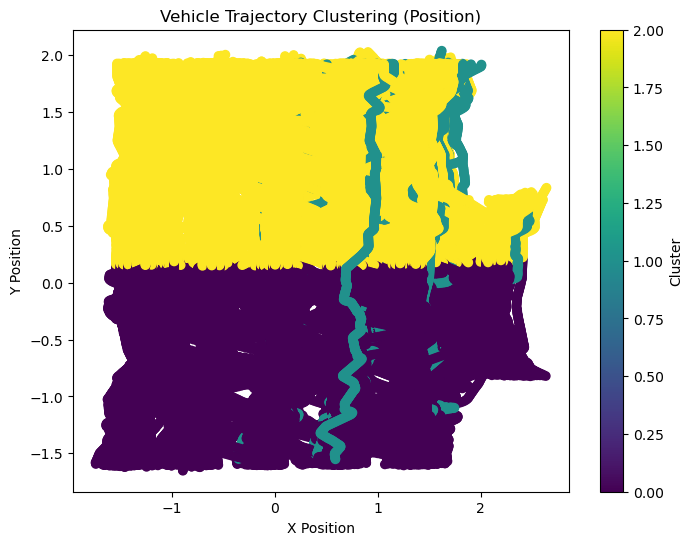

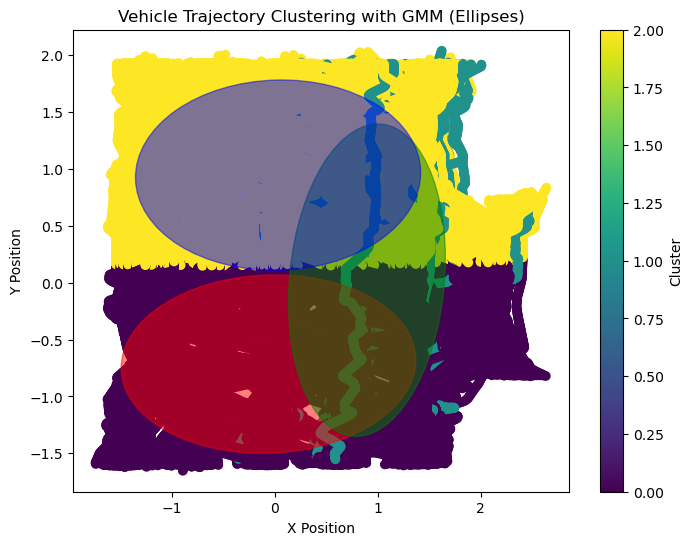

GMM Component Means (for each cluster):
[[-0.06184744 -0.71536954 -0.11202125]
 [ 0.89449013  0.02182304  4.35554988]
 [ 0.03138038  0.94524257 -0.09743274]]

Covariance Matrices (for each cluster):
[[[ 1.02300882e+00  2.44676367e-02 -1.83231469e-03]
  [ 2.44676367e-02  3.06827686e-01  6.29719351e-04]
  [-1.83231469e-03  6.29719351e-04  2.87357098e-01]]

 [[ 2.90114454e-01  7.33794250e-02 -8.73136444e-02]
  [ 7.33794250e-02  9.42650297e-01 -4.38630281e-03]
  [-8.73136444e-02 -4.38630281e-03  1.10977686e+01]]

 [[ 9.58426291e-01  1.43555737e-02 -4.77640486e-03]
  [ 1.43555737e-02  3.49753396e-01  4.38294810e-03]
  [-4.77640486e-03  4.38294810e-03  2.77370911e-01]]]


In [7]:
# 1. 2D Scatter Plot (X_Position vs Y_Position, color-coded by cluster)
plt.figure(figsize=(8, 6))
plt.scatter(
    scaled_features[:, 0], scaled_features[:, 1], c=labels, cmap="viridis", marker="o"
)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Vehicle Trajectory Clustering (Position)")
plt.colorbar(label="Cluster")
plt.show()

# 2. Scatter Plot with Confidence Ellipses (for each Gaussian component)
plt.figure(figsize=(8, 6))
plt.scatter(
    scaled_features[:, 0], scaled_features[:, 1], c=labels, cmap="viridis", marker="o"
)
ax = plt.gca()
colors = ["red", "green", "blue"]

for i in range(gmm.n_components):
    mean = gmm.means_[i]
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])  # Extract 2D covariance matrix (X, Y)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])  # Normalize the eigenvector

    # Angle of rotation
    angle = np.arctan(u[1] / u[0]) * 180 / np.pi

    # Create an ellipse based on the covariance (passing args as keyword arguments)
    ell = plt.matplotlib.patches.Ellipse(
        xy=mean[:2], width=v[0], height=v[1], angle=angle, color=colors[i], alpha=0.5
    )
    ax.add_patch(ell)

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Vehicle Trajectory Clustering with GMM (Ellipses)")
plt.colorbar(label="Cluster")
plt.show()

# 3. GMM Component Means and Covariances (for interpretability)
print("GMM Component Means (for each cluster):")
print(gmm.means_)
print("\nCovariance Matrices (for each cluster):")
print(gmm.covariances_)


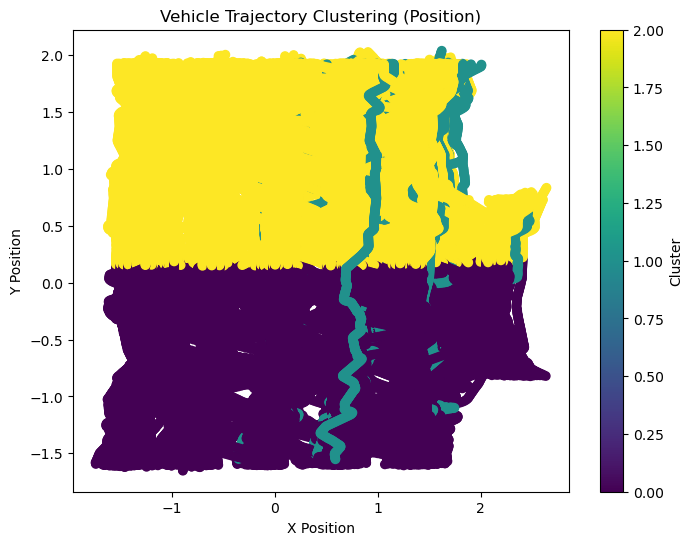

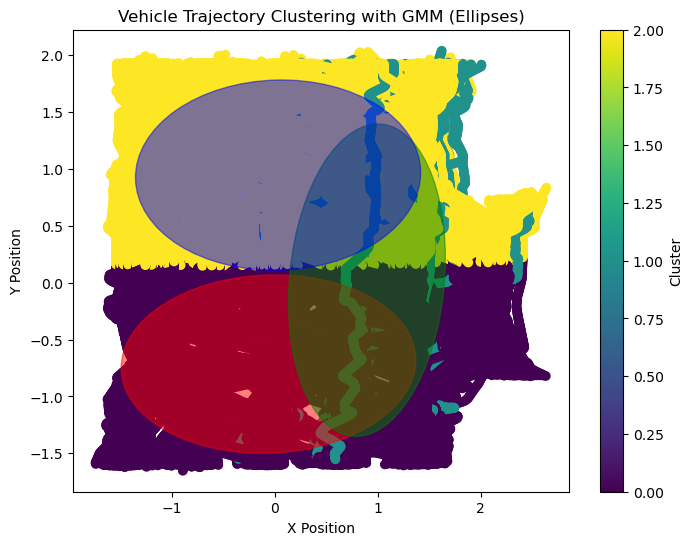

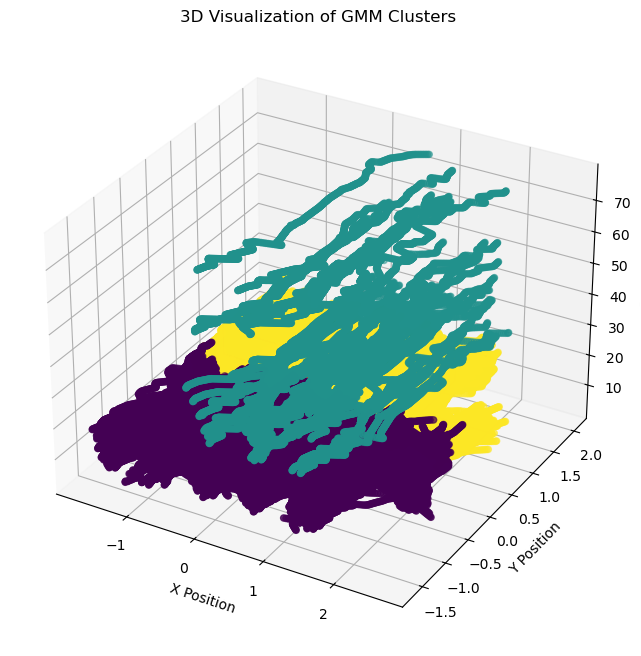

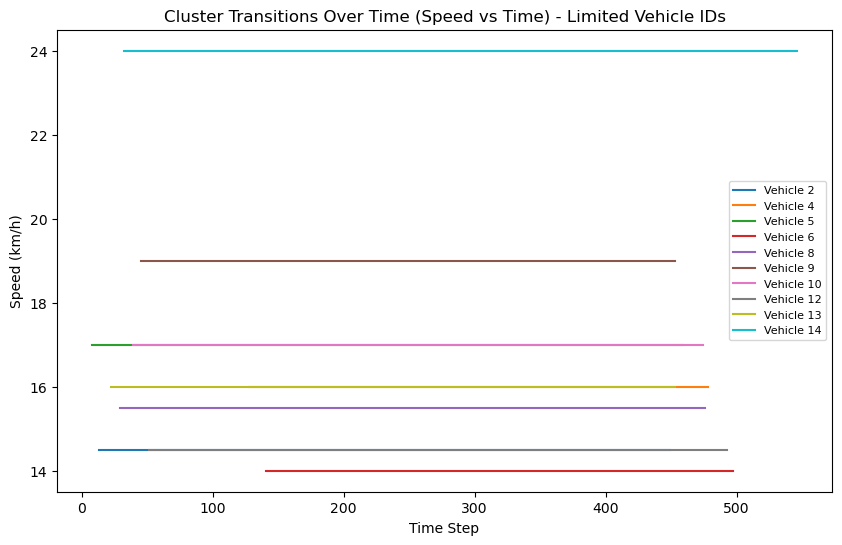

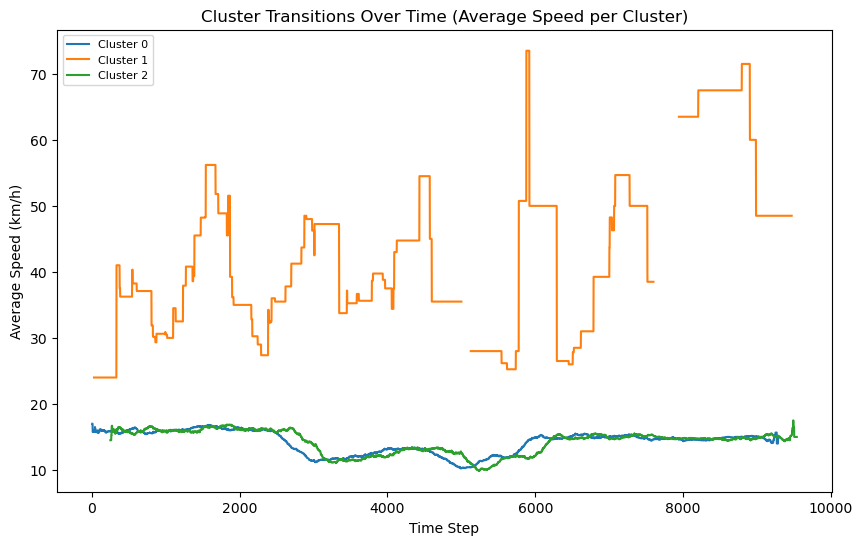

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# 1. 2D Scatter Plot (X_Position vs Y_Position, color-coded by cluster)
plt.figure(figsize=(8, 6))
plt.scatter(
    scaled_features[:, 0], scaled_features[:, 1], c=labels, cmap="viridis", marker="o"
)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Vehicle Trajectory Clustering (Position)")
plt.colorbar(label="Cluster")
plt.show()

# 2. Scatter Plot with Confidence Ellipses (for each Gaussian component)
plt.figure(figsize=(8, 6))
plt.scatter(
    scaled_features[:, 0], scaled_features[:, 1], c=labels, cmap="viridis", marker="o"
)
ax = plt.gca()
colors = ["red", "green", "blue"]

for i in range(gmm.n_components):
    mean = gmm.means_[i]
    covar = gmm.covariances_[i]
    v, w = np.linalg.eigh(covar[:2, :2])  # Extract 2D covariance matrix (X, Y)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])  # Normalize the eigenvector

    # Angle of rotation
    angle = np.arctan(u[1] / u[0]) * 180 / np.pi

    # Create an ellipse based on the covariance (passing args as keyword arguments)
    ell = plt.matplotlib.patches.Ellipse(
        xy=mean[:2], width=v[0], height=v[1], angle=angle, color=colors[i], alpha=0.5
    )
    ax.add_patch(ell)

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Vehicle Trajectory Clustering with GMM (Ellipses)")
plt.colorbar(label="Cluster")
plt.show()

# 3. 3D Scatter Plot (X_Position, Y_Position, Speed)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    scaled_features[:, 0],
    scaled_features[:, 1],
    features["Speed"],
    c=labels,
    cmap="viridis",
    marker="o",
)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Speed")
ax.set_title("3D Visualization of GMM Clusters")
plt.show()

# 4. Cluster Transition Over Time (Limited to 10 vehicle IDs to avoid clutter)
plt.figure(figsize=(10, 6))

# Select a subset of vehicle IDs (e.g., first 10 vehicles)
sample_vehicles = df["Vehicle_ID"].unique()[:10]

for vehicle_id in sample_vehicles:
    vehicle_data = df[df["Vehicle_ID"] == vehicle_id]
    plt.plot(
        vehicle_data["Time_Step"], vehicle_data["Speed"], label=f"Vehicle {vehicle_id}"
    )

plt.xlabel("Time Step")
plt.ylabel("Speed (km/h)")
plt.title("Cluster Transitions Over Time (Speed vs Time) - Limited Vehicle IDs")
plt.legend(loc="best", fontsize=8)
plt.show()

# 5. Cluster Transitions (Averaging Speed per Cluster over Time)
cluster_avg_speed = df.groupby(["Time_Step", "GMM_Cluster"])["Speed"].mean().unstack()

plt.figure(figsize=(10, 6))
for cluster_id in cluster_avg_speed.columns:
    plt.plot(
        cluster_avg_speed.index,
        cluster_avg_speed[cluster_id],
        label=f"Cluster {cluster_id}",
    )

plt.xlabel("Time Step")
plt.ylabel("Average Speed (km/h)")
plt.title("Cluster Transitions Over Time (Average Speed per Cluster)")
plt.legend(loc="best", fontsize=8)
plt.show()